# Análisis del modelo alométrico longitud-anchura

Para profundizar en el modelo alométrico definido por la expresión matemática {eq}`eq_peso-longitud_anchura` es preciso adoptar una estrategia rigurosamente secuencial que combine diagnóstico estadístico exhaustivo, exploración de formas funcionales alternativas y validación externa. A lo largo de este capítulo analizaremos cada uno de estas fases de forma pormenorizada.

## Preanálisis exploratorio (EDA)
Un primer análisis preliminar ya se realizó en el entregable E2.1 relativo a la ["Obtención y etiquetado del dataset"](../02/Dataset.ipynb). El análisis de la matriz de correlación indicó que, en el lenguado, el peso está fuertemente asociado con la longitud y la anchura (r≈0,94), mientras que su asociación con la altura (espesor corporal) es claramente menor (r≈0,86). En términos de varianza explicada, longitud y anchura individualmente capturan ~88% del comportamiento del peso (r²≈0,8836), frente a ~74% para la altura (r²≈0,7396). Esto es coherente con la biomecánica del pez plano: el peso depende del volumen, pero en especies deprimidas dorsoventralmente la variabilidad del área proyectada (aprox. longitud×anchura) domina sobre la variación del espesor. La correlación igualmente alta entre longitud y anchura (r≈0,94) sugiere una morfología con proporciones relativamente estables durante el crecimiento (isometría planiforme) o, al menos, una fuerte covariación de ambas dimensiones; en la práctica, esto implica multicolinealidad si se usan juntas en regresión. La correlación más baja de peso con la altura indica que el espesor es más variable entre individuos (condición corporal, estado nutricional, maduración gonadal), aportando información menos estable sobre el peso que las dimensiones planas. En conjunto, estas correlaciones significan que la masa del lenguado está principalmente determinada por su extensión superficial y que la altura añade variabilidad más idiosincrática.

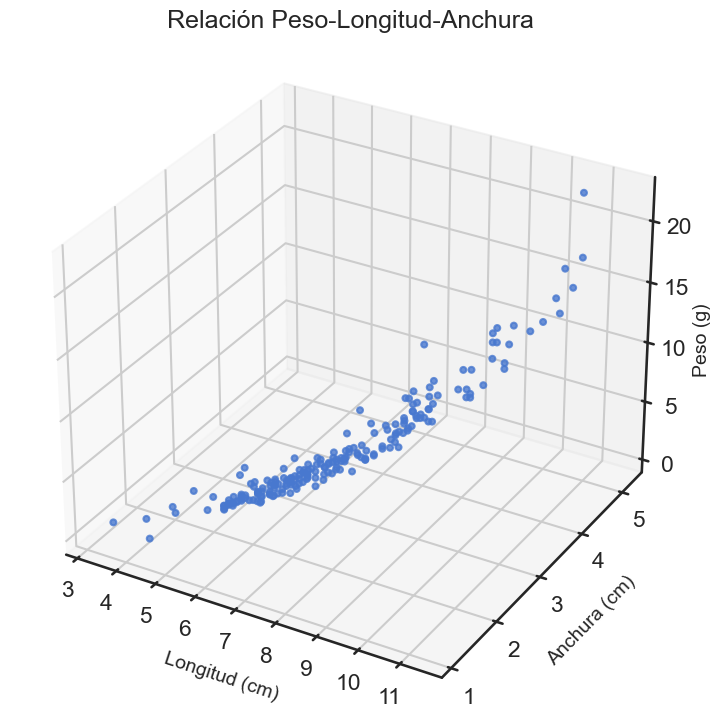

In [5]:
# SCATTER 3D PESO–LONGITUD–ANCHURA
# --------------------------------
fig = plt.figure(figsize=(8,8)) 
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Longitud (cm)'],
           df['Anchura (cm)'],
           df['Peso (g)'],
           s=18, alpha=0.8)

ax.set_xlabel('Longitud (cm)', labelpad=10, fontsize=14)
ax.set_ylabel('Anchura (cm)', labelpad=10, fontsize=14)
ax.set_zlabel('') # vaciamos el z-label “normal”

# Colocamos el texto como overlay 2-D para que no se recorte
fig.text(0.94, 0.52, 'Peso (g)', rotation=90,
         va='center', ha='center', fontsize=14)

ax.set_title("Relación Peso-Longitud-Anchura")
ax.set_box_aspect([1, 1, 0.8])  
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.90)
plt.show()


El diagrama de dispersión tridimensional muestra que los datos se distribuyen sobre una superficie típica de crecimiento alométrico: el peso ($W$) aumenta de forma supralineal con la longitud ($L$) y la anchura ($A$). Esta curvatura descarta cualquier ajuste plano clásico y avala la fórmula {eq}`eq_peso-longitud_anchura`; en coordenadas logarítmicas la nube se comprimiría prácticamente en un plano, lo que simplifica la estimación de $a$, $b$ y $k$ mediante regresión lineal múltiple sobre $\ln W$.

La sección horizontal del gráfico exhibe una correlación positiva marcada entre $L$ y $A$; sin embargo, la dispersión transversal confirma que la anchura aporta información independiente — es decir, $b$ no resulta redundante respecto a $a$. Además, la amplitud de la nube crece con el tamaño, evidenciando heterocedasticidad: los ejemplares grandes presentan mayor variabilidad relativa de peso. Este patrón exige, o bien la transformación log–log previa al ajuste, o bien el empleo de estimadores ponderados o robustos para preservar la validez inferencial.

En la proyección vertical se identifican varios individuos que se separan netamente de la masa principal: unos pocos muy pesados para su talla y uno o dos sorprendentemente livianos. Estos casos coinciden con los atípicos y deben revisarse individualmente —pudiendo tratarse de errores de registro, diferencias de condición corporal o etapas ontogénicas poco representadas.

**En conclusión, el análisis gráfico corrobora la idoneidad de un modelo alométrico en $L$ y $A$, subraya la necesidad de transformar logarítmicamente los datos o emplear métodos robustos y pone de relieve la importancia de manejar adecuadamente los valores atípicos para obtener estimaciones fiables de los parámetros biológicos.**

## Visualización de *outliers*

En el análisis exploratorio se ha comprobado la existencia de *outliers* y su visualización es fundamental para comprender su impacto en la construcción del modelo predictivo. Estos valores atípicos pueden surgir por errores en la medición, variabilidad natural en la población o condiciones excepcionales, y su presencia puede distorsionar los parámetros estadísticos y sesgar el modelo de regresión. Al representar gráficamente los *outliers* se facilita la identificación de observaciones aberrantes que podrían afectar la linealidad, homocedasticidad o normalidad de los residuos. Además, su visualización permite evaluar si deben ser tratados mediante estrategias como winsorización, eliminación o imputación robusta, optimizando así la generalización del modelo.

Para contabilizar y visualizar estos *outliers* vamos a emplear primeramente un enfoque univariado (detección en una dimensión) para después aplicar un enfoque multivariado que permite la detección en múltiples variables.

### Métodos univariados (detección en una dimensión)

- **Rango intercuartílico (IQR)** se define como la amplitud $Q_{3}-Q_{1}$, donde $Q_{1}$ y $Q_{3}$ son, respectivamente, los percentiles 25% y 75% de la distribución ordenada de una variable aleatoria continua. Constituye una medida robusta de dispersión, insensible a colas pesadas o valores aberrantes, pues encapsula el 50% central de las observaciones. En procedimientos de depuración de datos, el criterio aplicable considera atípica toda observación $x$ que verifique $x < Q_{1}-k\cdot \text{IQR}$ o $x > Q_{3}+k\cdot \text{IQR}$, con $k=1.5$ como valor convencional. Este umbral utiliza el IQR como escala de variabilidad intrínseca y permite identificar *outliers* sin asumir normalidad ni recurrir a momentos de orden superior, favoreciendo diagnósticos estadísticos robustos en muestras heterogéneas.
- **El Z-score**, o puntuación estándar, es una métrica estadística que cuantifica cuántas desviaciones estándar se aleja una observación del valor medio de la distribución, expresado como $Z=\dfrac{X−μ}{σ}$, donde $X$ es el valor observado, $μ$ la media poblacional y $σ$ la desviación estándar. Este método es particularmente útil para identificar *outliers* en distribuciones normales o aproximadamente normales, considerándose valores atípicos aquellos con $∣Z∣>3$ (umbral que abarca el 99.7% de los datos bajo la curva gaussiana). Sin embargo, su eficacia disminuye en distribuciones sesgadas o con colas pesadas, ya que la media y la desviación estándar son sensibles a valores extremos.


In [6]:
# -------------------------------------------------
#    METODOS UNIVARIADOS
# -------------------------------------------------
def iqr_mask(series, k=1.5):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    return (series < q1 - k*iqr) | (series > q3 + k*iqr)

# ********************************
#    IQR sobre cada variable
# ********************************
mask_iqr = (
    iqr_mask(df['Peso (g)']) |
    iqr_mask(df['Longitud (cm)']) |
    iqr_mask(df['Anchura (cm)'])
)

# Generamos una copia del data frame original
df_outliers = df.copy()

# Añadimos los outliers detectados
df_outliers['out_IQR'] = mask_iqr


# Filtrar outliers y añadir columnas de diagnóstico
outliers_iqr = df_outliers[mask_iqr].copy()
outliers_iqr['Razón_outlier'] = ""

# Identificar qué variables contribuyeron

if 'Longitud (cm)' in df.columns:
    outliers_iqr.loc[iqr_mask(df['Longitud (cm)'])[mask_iqr], 'Razón_outlier'] += "Longitud; "
if 'Anchura (cm)' in df.columns:
    outliers_iqr.loc[iqr_mask(df['Anchura (cm)'])[mask_iqr], 'Razón_outlier'] += "Anchura; "
if 'Peso (g)' in df.columns:
    outliers_iqr.loc[iqr_mask(df['Peso (g)'])[mask_iqr], 'Razón_outlier'] += "Peso; "

# Mostrar resultado
print(f"IQR: Número de outliers detectados IQR: {len(outliers_iqr)}\n")
outliers_iqr.head(len(outliers_iqr))

IQR: Número de outliers detectados IQR: 11



,Peso (g),Longitud (cm),Anchura (cm),Altura (cm),out_IQR,Razón_outlier
194,13.45,9.7,4.0,0.6,True,Peso;
197,13.56,9.7,4.1,0.6,True,Peso;
200,14.13,10.1,4.1,0.7,True,Peso;
201,14.04,10.5,4.1,0.7,True,Peso;
202,14.67,10.7,4.2,0.7,True,Peso;
203,15.65,10.7,4.5,0.6,True,Peso;
204,14.50,10.8,4.5,0.6,True,Peso;
205,19.88,11.4,4.4,0.9,True,Peso;
206,16.47,11.0,4.6,0.7,True,Peso;
207,17.04,10.6,4.8,0.7,True,Peso;


In [7]:
# ********************************
#    Z-SCORE sobre cada variable
# ********************************

from scipy.stats import zscore

def zscore_mask(series, threshold=3):
    z_scores = zscore(series)
    return abs(z_scores) > threshold

mask_zscore = (
    zscore_mask(df['Peso (g)']) |
    zscore_mask(df['Longitud (cm)']) |
    zscore_mask(df['Anchura (cm)'])
)
# Introducimos los outliers en el dataframe correspondiente
df_outliers["out_ZScore"] = mask_zscore

# Filtrar outliers y añadir columnas de diagnóstico
outliers_zscore = df_outliers[mask_zscore].copy()
outliers_zscore['Razón_outlier'] = ""

# Añadir Z-scores para cada variable
for col in ['Peso (g)', 'Longitud (cm)', 'Anchura (cm)']:
    if col in df.columns:
        outliers_zscore[f'Z_{col}'] = zscore(df[col])[mask_zscore]

# Identificar qué variables contribuyeron
if 'Longitud (cm)' in df.columns:
    outliers_zscore.loc[zscore_mask(df['Longitud (cm)'])[mask_zscore], 'Razón_outlier'] += "Longitud; "
if 'Anchura (cm)' in df.columns:
    outliers_zscore.loc[zscore_mask(df['Anchura (cm)'])[mask_zscore], 'Razón_outlier'] += "Anchura; "
if 'Peso (g)' in df.columns:
    outliers_zscore.loc[zscore_mask(df['Peso (g)'])[mask_zscore], 'Razón_outlier'] += "Peso; "

# Mostrar resultado
print(f"Z-Score: Número de outliers detectados (|Z| > 3): {len(outliers_zscore)}\n")
display(outliers_zscore.style.format({f'Z_{col}': "{:.2f}" for col in ['Peso (g)', 'Longitud (cm)', 'Anchura (cm)'] if col in df.columns}))

Z-Score: Número de outliers detectados (|Z| > 3): 4



,Peso (g),Longitud (cm),Anchura (cm),Altura (cm),out_IQR,out_ZScore,Razón_outlier,Z_Peso (g),Z_Longitud (cm),Z_Anchura (cm)
205,19.880000,11.400000,4.400000,0.900000,True,True,Peso;,4.01,2.77,2.31
206,16.470000,11.000000,4.600000,0.700000,True,True,Peso;,3.07,2.50,2.60
207,17.040000,10.600000,4.800000,0.700000,True,True,Peso;,3.22,2.23,2.89
208,21.980000,10.600000,5.200000,0.800000,True,True,Anchura; Peso;,4.59,2.23,3.46


### Métodos multivariados

**Isolation Forest** es un algoritmo de detección de anomalías no supervisado basado en el principio de particiones aleatorias. A partir de un conjunto de $n$ observaciones $\{\mathbf{x}{i}\}{i=1}^{n}\subset\mathbb{R}^{p}$, se construye un bosque de $t$ árboles binarios denominados *iTrees*; cada *iTree* se genera seleccionando recursivamente, de forma aleatoria, (i) una característica $j\in\{1,\dots,p\}$ y (ii) un valor de corte $\theta$ comprendido entre los valores mínimo y máximo de la característica en el subconjunto actual. El proceso continúa hasta que la partición contiene un único punto o alcanza una profundidad máxima $h_{\max}$. La idea fundamental es que las observaciones anómalas, al hallarse escasamente representadas y en regiones periféricas del espacio de características, tienden a quedar aisladas tras un número bajo de divisiones. Para cada muestra $\mathbf{x}$ se define una profundidad promedio $E[h(\mathbf{x})]$ —promediada sobre los $t$ árboles— y de ella se deduce la puntuación de anomalía

```{math}
:label: eq_iforest_1
s(\mathbf{x}) = 2^{-\frac{E[h(\mathbf{x})]}{c(n)}},
\qquad
c(n) = H_{n-1}-\frac{2(n-1)}{n},
```

donde $H_{n}$ es el $n$-ésimo número armónico. Los valores de $s(\mathbf{x})$ se normalizan en $[0,1]$; puntuaciones próximas a 1 indican observaciones susceptibles de ser outliers. El esquema evita suposiciones paramétricas sobre la forma de la distribución, es eficiente en alta dimensionalidad $(O(t\,n\log n))$ y permite fijar *a priori* la proporción esperada de anomalías mediante el parámetro `contamination`, lo que lo hace idóneo para depuración robusta de conjuntos de datos complejos. 

Para abordar este algoritmo eliminamos de nuestro *dataset* la variable `Altura` porque como ya concluimos anteriormente su exclusión no produce pérmida fundamental de información y sí podria afectar a los resultados. Previamente a la aplicacion del algoritmo es necesario normalizar (estandarizar) las columnas seleccionadas para garantizar la efectividad del algoritmo en la detección de anomalías. Al estandarizar las variables mediante la transformación $\dfrac{X−μ}{σ}$, se homogenizan las escalas de todas las características, evitando que aquellas con magnitudes mayores dominen artificialmente el cálculo de anomalías. Este paso es esencial porque *Isolation Forest*, al basarse en particiones aleatorias del espacio de características, puede generar sesgos en conjuntos de datos con variables en escalas heterogéneas. La estandarización no solo mejora la sensibilidad del modelo a patrones multivariados de *outliers*, sino que también facilita la interpretación de los *scores* de anomalía al operar en un espacio métrico coherente. Adicionalmente, al fijar la media en 0 y la varianza en 1, se optimiza el rendimiento computacional del algoritmo, ya que las distancias utilizadas en las particiones aleatorias de los árboles reflejan contribuciones equilibradas de todas las variables.

Nº de outliers detectados: 36


,Peso (g),Longitud (cm),Anchura (cm),Altura (cm)
0,0.46,3.3,1.3,0.2
1,1.08,4.5,1.1,0.3
2,0.67,3.9,1.5,0.2
3,0.98,4.4,1.7,0.3
4,0.93,4.2,1.8,0.3
5,1.89,4.5,2.0,0.4
6,1.60,5.1,1.8,0.3
92,3.06,6.0,2.9,0.4
141,6.96,7.2,3.3,0.5
153,3.40,6.8,3.9,0.4


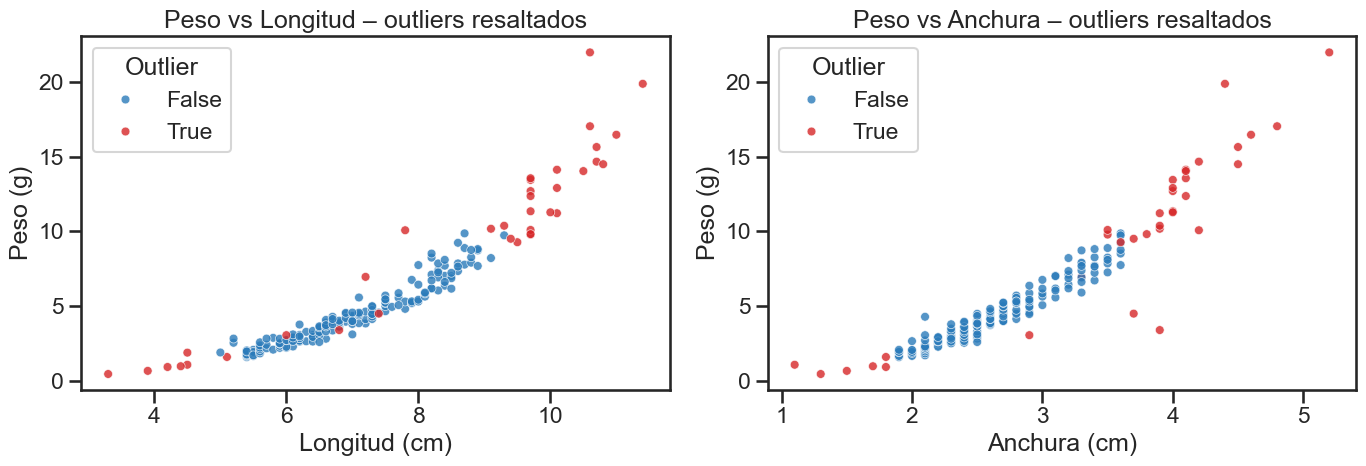

In [8]:
# ********************************
#  ISOLATION FOREST MULTIVARIABLE
# ********************************

iso = IsolationForest(contamination='auto', random_state=42)

# Eliminamos la columna altura del dataset
iso_cols = ['Peso (g)', 'Longitud (cm)', 'Anchura (cm)']
X = df[iso_cols]

# Normalizamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

labels_iso = iso.fit_predict(X_scaled)
mask_iso = labels_iso == -1

# Guardamos los ouliers en el dataframe
df_outliers["out_iso"] = mask_iso

print(f"Nº de outliers detectados: {df_outliers['out_iso'].sum()}")
display(df[df_outliers["out_iso"]])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfica 1
sns.scatterplot(data=df_outliers, x='Longitud (cm)', y='Peso (g)',
                hue='out_iso', ax=ax1,
                palette={False: "#2b7bba", True: "#d62728"},
                alpha=0.8, s=40)
ax1.set_title("Peso vs Longitud – outliers resaltados")
ax1.legend(title="Outlier", loc="upper left")

# Gráfica 2
sns.scatterplot(data=df_outliers, x='Anchura (cm)', y='Peso (g)',
                hue='out_iso', ax=ax2,
                palette={False: "#2b7bba", True: "#d62728"},
                alpha=0.8, s=40)
ax2.set_title("Peso vs Anchura – outliers resaltados")
ax2.legend(title="Outlier", loc="upper left")

plt.tight_layout()
plt.show()

Los tres métodos empelados para encontrar outliers presentan diferentes números de *outliers*. Dado que cada algoritmo de detección de *outliers* se fundamenta en marcos estadísticos divergentes —el método del rango intercuartílico (IQR) opera bajo un enfoque univariante robusto basado en cuantiles, pero carece de sensibilidad para capturar relaciones multivariadas; el Z-score presupone una distribución cuasi-normal y cuantifica desviaciones en unidades de escala estándar; mientras que Isolation Forest implementa un paradigma no paramétrico que aisla observaciones atípicas en espacios p-dimensionales mediante hiperplanos aleatorios—, se deriva como consecuencia teórica que los conjuntos de anomalías identificados presentarán necesariamente solapamientos parciales.

Un análisis de conjuntos (operaciones de intersección y diferencia) puede ser una metodología adecuada para: a) discriminar entre outliers de alta consistencia (aquellos que simultáneamente exceden los umbrales de dispersión no paramétrica, violan los supuestos de normalidad y manifiestan rareza en la topología multivariante), y b) identificar observaciones cuya clasificación como atípicas es artefactual, dependiente de los supuestos específicos de cada modelo. Este protocolo de validación cruzada minimiza los errores de Tipo I (falsos positivos), incrementa la validez del preprocesamiento estadístico y permite así una cuantificación formal del sesgo metodológico inherente a cada técnica.

El objetivo de este análisis de conjuntos es delimitar aquellas observaciones que son identificadas como *outliers* por al menos dos métodos independientes, estableciendo así un criterio de consenso que refuerza la fiabilidad de la detección. Cuando un mismo dato es marcado como anómalo por múltiples técnicas —cada una basada en supuestos estadísticos distintos (p. ej., dispersión robusta, normalidad, o rareza multivariante)—, la probabilidad de que se trate de un verdadero valor aberrante, y no de un artefacto metodológico, aumenta significativamente.

Por tanto, estos *outliers* multimodales deben considerarse como observaciones genuinamente anómalas, ya sea debido a errores de medición o comportamientos sistémicos atípicos, y su exclusión o tratamiento se justifica para garantizar la validez inferencial de los análisis posteriores.


In [9]:
# Conjuntos y solapamientos
set_iqr = set(df_outliers.index[df_outliers['out_IQR']])
set_zscore   = set(df_outliers.index[df_outliers['out_ZScore']])
set_if  = set(df_outliers.index[df_outliers['out_iso']])

print("─ Outliers por método ─\n")
print(f"IQR                : {len(set_iqr)}")
print(f"Z-Score |z| > 3    : {len(set_zscore)}")
print(f"Isolation Forest   : {len(set_if)}\n")

idx_common = np.array([
    sorted(set_iqr & set_zscore),
    sorted(set_iqr & set_if),
    sorted(set_zscore & set_if),
    sorted(set_iqr & set_zscore & set_if)
    ], dtype=object) # dtype=object para listas de distinto tamaño

print("─ Intersecciones ─\n")
print(f"IQR ∩ Z-Score: {len(set_iqr & set_zscore)}")
outliers_common = df_outliers.loc[idx_common[0]] 
display(outliers_common)

print(f"IQR ∩ Isolation Forest     : {len(set_iqr & set_if)}")
display(df_outliers.loc[idx_common[1]])

print(f"Z-Score ∩ Isolation Forest : {len(set_zscore & set_if)}")
display(df_outliers.loc[idx_common[2]])

print(f"IQR ∩ Z-Score ∩ IF         : {len(set_iqr & set_zscore & set_if)}")
display(df_outliers.loc[idx_common[3]])

─ Outliers por método ─

IQR                : 11
Z-Score |z| > 3    : 4
Isolation Forest   : 36

─ Intersecciones ─

IQR ∩ Z-Score: 4


,Peso (g),Longitud (cm),Anchura (cm),Altura (cm),out_IQR,out_ZScore,out_iso
205,19.88,11.4,4.4,0.9,True,True,True
206,16.47,11.0,4.6,0.7,True,True,True
207,17.04,10.6,4.8,0.7,True,True,True
208,21.98,10.6,5.2,0.8,True,True,True


IQR ∩ Isolation Forest     : 11


,Peso (g),Longitud (cm),Anchura (cm),Altura (cm),out_IQR,out_ZScore,out_iso
194,13.45,9.7,4.0,0.6,True,False,True
197,13.56,9.7,4.1,0.6,True,False,True
200,14.13,10.1,4.1,0.7,True,False,True
201,14.04,10.5,4.1,0.7,True,False,True
202,14.67,10.7,4.2,0.7,True,False,True
203,15.65,10.7,4.5,0.6,True,False,True
204,14.50,10.8,4.5,0.6,True,False,True
205,19.88,11.4,4.4,0.9,True,True,True
206,16.47,11.0,4.6,0.7,True,True,True
207,17.04,10.6,4.8,0.7,True,True,True


Z-Score ∩ Isolation Forest : 4


,Peso (g),Longitud (cm),Anchura (cm),Altura (cm),out_IQR,out_ZScore,out_iso
205,19.88,11.4,4.4,0.9,True,True,True
206,16.47,11.0,4.6,0.7,True,True,True
207,17.04,10.6,4.8,0.7,True,True,True
208,21.98,10.6,5.2,0.8,True,True,True


IQR ∩ Z-Score ∩ IF         : 4


,Peso (g),Longitud (cm),Anchura (cm),Altura (cm),out_IQR,out_ZScore,out_iso
205,19.88,11.4,4.4,0.9,True,True,True
206,16.47,11.0,4.6,0.7,True,True,True
207,17.04,10.6,4.8,0.7,True,True,True
208,21.98,10.6,5.2,0.8,True,True,True


Los tres métodos usados coinciden en señalar los cuatros registros 205 - 208 como *outliers* lo cual es indicativo de posibles errores o individuos excepcionales en nuestro dataset y deberían no ser considerados en una mejora del modelo alométrico inferido. Por otro lado los registros 194-204 detectados como valores anómalos por los métodos IRQ e Isolation Forest pueden representar sesgo de muestreo, diferencias de condición o simple variabilidad natural.

La relación empírica $𝑊=𝑘 \cdot L^a \cdot A^b$ es, por naturaleza, multiplicativa; de ella se deriva que la varianza de $𝑊$ crece proporcionalmente a $𝐿$ y $A$. Este comportamiento genera heterocedasticidad: los residuos asociados a los ejemplares grandes presentan una dispersión mucho mayor que los de los de menor tramaño, Bajo esta condición, las métricas univariantes (IQR, desviaciones 𝑧) y los algoritmos multivariantes (Isolation Forest) operan con escalas que “inflan” artificialmente la distancia de los ejemplares grandes y “comprimen” la de los pequeños, sesgando la detección de valores atípicos. Aplicar una **transformación logarítmica** $ln(⋅)$
convierte esa relación de potencia en un modelo lineal aditivo y estabiliza la varianza, de modo que la dispersión residual es aproximadamente homocedástica y más simétrica. Los trabajos de [Packart (2013)](https://doi.org/10.1111/bij.12038) y posteriormente de  [West (2022)](https://doi.org/10.1177/00045632211050531) han demostrado que, tras la aplicacón de una transformada logarítmica, las colas asimétricas se reducen y las pruebas basadas en desviación estándar recuperan su tasa nominal de error I, recomendando explícitamente esta práctica previa a cualquier inferencia paramétrica.

En estudios ictiológicos recientes la práctica se ha consolidado como estándar. [Rodríguez-García et al. (2023)](https://doi.org/10.3390/fishes8050222) aplican la transformación logarítmica antes de filtrar anomalías en más de 40 especies descartadas por la flota del golfo de Cádiz y resaltan que, tras el log, sólo persiste un subconjunto mínimo de registros verdaderamente aberrantes, mientras que la mayoría de los *outliers* iniciales se explican por la escala multiplicativa del crecimiento. [Xia et al. (2022)](https://doi.org/10.1016/j.ejar.2022.07.005) en seis especies del Yangtsé— siguen este protocolo: estiman los parámetros en escala log y evalúan la calidad de ajuste y los residuos sobre los datos transformados, obteniendo un filtrado de anomalías significativamente más fiable.

````{admonition} Conclusión
:class: tip
En nuestro caso, transformar a $ln$ permitirá redefinir los umbrales de IQR y Z-score sobre distribuciones casi simétricas y comparables, validar la relevancia biológica de los registros 205–208 —ahora *outliers* unánimes— y re-evaluar los casos 194–204 en un entorno de varianza estabilizada, evitando expulsar datos válidos que sólo parecían extremos por efecto de escala.
````

## Transformada logarítmica

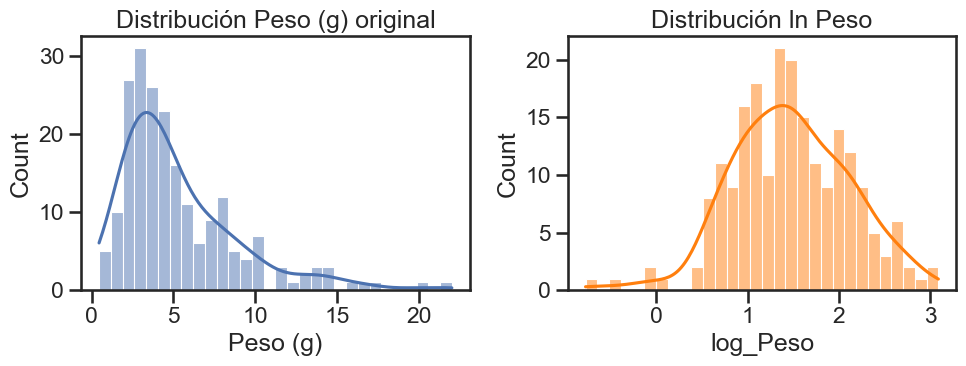

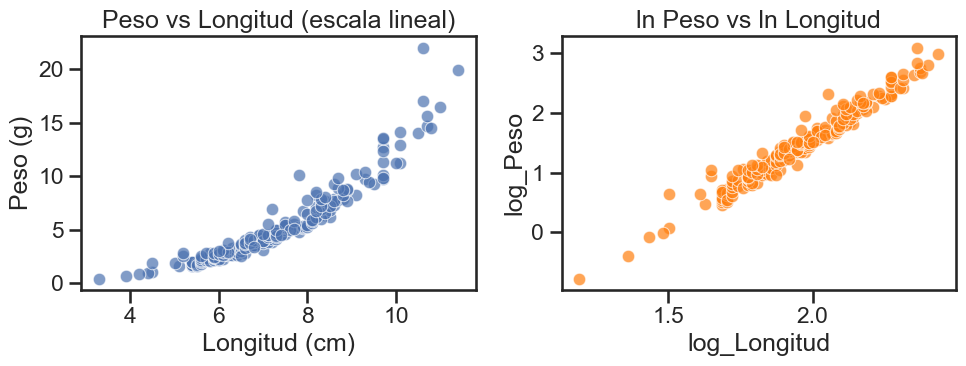

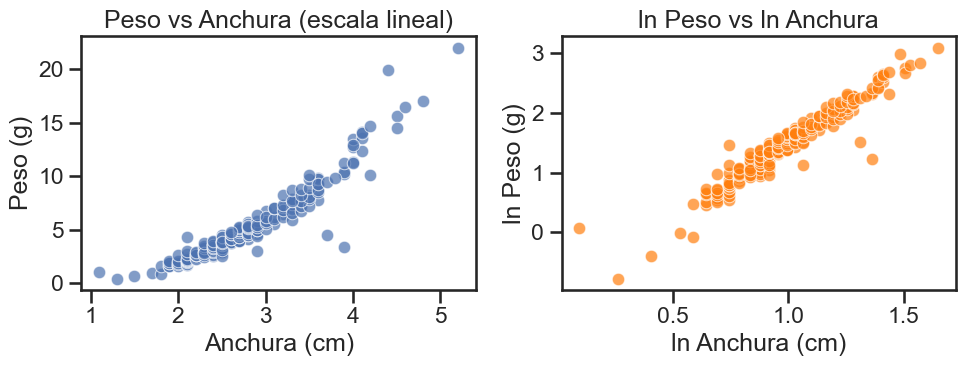

In [10]:
# ===============================================================
#     Transformación logarítmica, visualización preliminar
#          y re-detección de outliers
# ===============================================================

# ---------------------------------------------------------------
# 1.  Seleccionar y depurar variables numéricas
# ---------------------------------------------------------------
numeric_cols = ['Peso (g)', 'Longitud (cm)', 'Anchura (cm)']

#eps = 1e-6                                 # evita log(0)
#df[numeric_cols] = df[numeric_cols].clip(lower=eps)

# ---------------------------------------------------------------
# 2.  Transformación log-natural
# ---------------------------------------------------------------
df_log = df[numeric_cols].copy()
df_log = df_log[df_log['Peso (g)'] > 0]

df_log['log_Peso'] = np.log(df_log['Peso (g)'])
df_log['log_Longitud'] = np.log(df_log['Longitud (cm)'])
df_log['log_Anchura'] = np.log(df_log['Anchura (cm)'])

# ---------------------------------------------------------------
# 3.  Visualizar efecto de la transformación
# ---------------------------------------------------------------
sns.set(style="ticks", context="talk")

## 3-a. Histogramas Peso: original vs ln
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(df['Peso (g)'], ax=ax[0], bins=30, kde=True)
ax[0].set_title("Distribución Peso (g) original")
sns.histplot(df_log['log_Peso'], ax=ax[1], bins=30, kde=True, color="#ff7f0e")
ax[1].set_title("Distribución ln Peso")
plt.tight_layout()
plt.show()

## 3-b. Scatter Peso–Longitud: lineal vs log-log
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(data=df, x='Longitud (cm)', y='Peso (g)', ax=ax[0], alpha=0.7)
ax[0].set_title("Peso vs Longitud (escala lineal)")
sns.scatterplot(x=df_log['log_Longitud'], y=df_log['log_Peso'], ax=ax[1], alpha=0.7, color="#ff7f0e")
ax[1].set_title("ln Peso vs ln Longitud")
plt.tight_layout()
plt.show()


## 3-c. Scatter Peso–Anchura: lineal vs log-log
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(data=df,
                x='Anchura (cm)', y='Peso (g)',
                alpha=0.7, ax=ax[0])
ax[0].set_title("Peso vs Anchura (escala lineal)")
ax[0].set_xlabel("Anchura (cm)")
ax[0].set_ylabel("Peso (g)")
sns.scatterplot(x=df_log['log_Anchura'],
                y=df_log['log_Peso'],
                alpha=0.7, color="#ff7f0e", ax=ax[1])
ax[1].set_title("ln Peso vs ln Anchura")
ax[1].set_xlabel("ln Anchura (cm)")
ax[1].set_ylabel("ln Peso (g)")

plt.tight_layout()
plt.show()



Como se puede apreciar en las gráficas obtenidas, el uso de la transformada logarítmica produce una normalización de la distribución sesgada del peso y una linealización de las relaciones exponenciales de Peso vs. Longitud y Peso vs. Anchura. En el primer caso, normalizaciíón, esto nos va a permitir un mejor ajuste a modelos paramétricos. En el segundo caso, linealización, nos va a permitir aplicar unas regresión lineal multiparamétrica sencilla para poder encontar los factores $k$, $a$ y $b$ que definen el modelo alométrico de la ecuación {eq}`eq_peso-longitud_anchura`.

Nuestro siguiente paso es detectar los *outliers* por los tres métodos usados con anterioridad (IRQ, Z-Scores e Isolation Forest) con los dtaos transformados.

In [11]:
# ---------------------------------------------------------------
# 4.  Detección de outliers en escala log
# ---------------------------------------------------------------

# Método IQR
def detect_outliers_iqr(col, k=1.5):
    q1, q3 = col.quantile([0.25, 0.75])
    iqr = q3 - q1
    return (col < q1 - k*iqr) | (col > q3 + k*iqr)

mask_iqr_log = (
    detect_outliers_iqr(df_log['log_Peso']) |
    detect_outliers_iqr(df_log['log_Longitud']) |
    detect_outliers_iqr(df_log['log_Anchura'])
)

# Método Z-score
z_scores = np.abs(stats.zscore(df_log[['log_Peso', 'log_Longitud', 'log_Anchura']]))
mask_z_log = (z_scores > 3).any(axis=1)

# Método Isolation Forest
X_scaled_log = StandardScaler().fit_transform(df_log[['log_Longitud', 'log_Anchura', 'log_Peso']])
iso_forest = IsolationForest(contamination='auto',random_state=42)
mask_if_log = iso_forest.fit_predict(X_scaled_log) == -1

# Mostrar resultados
df_log['out_IQR_log'] = mask_iqr_log
print("Outliers método IQR")
display(df_log[df_log['out_IQR_log']])

df_log['out_Z_log']   = mask_z_log
print("Outliers método Z-Score")
display(df_log[df_log['out_Z_log']])

print("Outliers método Isolation Forest")
df_log['out_IF_log']  = mask_if_log
display(df_log[df_log['out_IF_log']])


Outliers método IQR


,Peso (g),Longitud (cm),Anchura (cm),log_Peso,log_Longitud,log_Anchura,out_IQR_log
0,0.46,3.3,1.3,-0.776529,1.193922,0.262364,True
1,1.08,4.5,1.1,0.076961,1.504077,0.095310,True
2,0.67,3.9,1.5,-0.400478,1.360977,0.405465,True


Outliers método Z-Score


,Peso (g),Longitud (cm),Anchura (cm),log_Peso,log_Longitud,log_Anchura,out_IQR_log,out_Z_log
0,0.46,3.3,1.3,-0.776529,1.193922,0.262364,True,True
1,1.08,4.5,1.1,0.076961,1.504077,0.095310,True,True


Outliers método Isolation Forest


,Peso (g),Longitud (cm),Anchura (cm),log_Peso,log_Longitud,log_Anchura,out_IQR_log,out_Z_log,out_IF_log
0,0.46,3.3,1.3,-0.776529,1.193922,0.262364,True,True,True
1,1.08,4.5,1.1,0.076961,1.504077,0.095310,True,True,True
2,0.67,3.9,1.5,-0.400478,1.360977,0.405465,True,False,True
3,0.98,4.4,1.7,-0.020203,1.481605,0.530628,False,False,True
4,0.93,4.2,1.8,-0.072571,1.435085,0.587787,False,False,True
5,1.89,4.5,2.0,0.636577,1.504077,0.693147,False,False,True
6,1.60,5.1,1.8,0.470004,1.629241,0.587787,False,False,True
7,1.90,5.0,2.0,0.641854,1.609438,0.693147,False,False,True
8,1.59,5.4,1.9,0.463734,1.686399,0.641854,False,False,True
42,2.83,5.2,2.5,1.040277,1.648659,0.916291,False,False,True


In [12]:
# ===============================================================
#  Comparativa de intersecciones entre los tres métodos (log)
# ===============================================================

# --- Conjuntos de índices por método ---
set_iqr_log = set(df_log.index[df_log['out_IQR_log']])
set_z_log   = set(df_log.index[df_log['out_Z_log']])
set_if_log  = set(df_log.index[df_log['out_IF_log']])

# --- DataFrame que contiene únicamente los registros marcados por algún método ---
df_log['out_any_log'] = df_log[['out_IQR_log','out_Z_log','out_IF_log']].any(axis=1)

df_outliers = df_log[df_log['out_any_log']]

# --- Construimos un array con las cuatro intersecciones ---
idx_common = np.array([
    sorted(set_iqr_log & set_z_log),                # IQR ∩ Z-Score
    sorted(set_iqr_log & set_if_log),               # IQR ∩ IF
    sorted(set_z_log   & set_if_log),               # Z-Score ∩ IF
    sorted(set_iqr_log & set_z_log & set_if_log)    # IQR ∩ Z-Score ∩ IF
], dtype=object)   # dtype=object permite listas de longitud variable

print("─ Intersecciones (escala log) ─\n")

print(f"IQR ∩ Z-Score              : {len(idx_common[0])}")
display(df_outliers.loc[idx_common[0]])

print(f"IQR ∩ Isolation Forest     : {len(idx_common[1])}")
display(df_outliers.loc[idx_common[1]])

print(f"Z-Score ∩ Isolation Forest : {len(idx_common[2])}")
display(df_outliers.loc[idx_common[2]])

print(f"IQR ∩ Z-Score ∩ IF         : {len(idx_common[3])}")
display(df_outliers.loc[idx_common[3]])

─ Intersecciones (escala log) ─

IQR ∩ Z-Score              : 2


,Peso (g),Longitud (cm),Anchura (cm),log_Peso,log_Longitud,log_Anchura,out_IQR_log,out_Z_log,out_IF_log,out_any_log
0,0.46,3.3,1.3,-0.776529,1.193922,0.262364,True,True,True,True
1,1.08,4.5,1.1,0.076961,1.504077,0.095310,True,True,True,True


IQR ∩ Isolation Forest     : 3


,Peso (g),Longitud (cm),Anchura (cm),log_Peso,log_Longitud,log_Anchura,out_IQR_log,out_Z_log,out_IF_log,out_any_log
0,0.46,3.3,1.3,-0.776529,1.193922,0.262364,True,True,True,True
1,1.08,4.5,1.1,0.076961,1.504077,0.095310,True,True,True,True
2,0.67,3.9,1.5,-0.400478,1.360977,0.405465,True,False,True,True


Z-Score ∩ Isolation Forest : 2


,Peso (g),Longitud (cm),Anchura (cm),log_Peso,log_Longitud,log_Anchura,out_IQR_log,out_Z_log,out_IF_log,out_any_log
0,0.46,3.3,1.3,-0.776529,1.193922,0.262364,True,True,True,True
1,1.08,4.5,1.1,0.076961,1.504077,0.095310,True,True,True,True


IQR ∩ Z-Score ∩ IF         : 2


,Peso (g),Longitud (cm),Anchura (cm),log_Peso,log_Longitud,log_Anchura,out_IQR_log,out_Z_log,out_IF_log,out_any_log
0,0.46,3.3,1.3,-0.776529,1.193922,0.262364,True,True,True,True
1,1.08,4.5,1.1,0.076961,1.504077,0.095310,True,True,True,True


Los tres métodos usados coinciden en marcar como *outliers* los registros con índice $0$ y $1$ coincidente, en gran parte, con la gráfica de distribucion de peso en la transformada logaritmica.

Hay que tener en cuenta que en la deteccion de valores anómalos con los datos originales, el peso aumenta de manera multiplicativa con la longitud y la anchura: a medida que los peces crecen, la variabilidad absoluta de sus masas se dispara. Los métodos clásicos de detección (IQR, Z-score o Isolation Forest) se basan en distancias lineales; por eso señalan como atípicos a los cuatro ejemplares más pesados: su desviación, medida en gramos, es mucho mayor que la de cualquier juvenil.

Al pasar los datos a escala logarítmica convertimos esa relación multiplicativa en una relación aditiva y hacemos que la varianza sea prácticamente constante en todo el rango de tallas. La compresión de la cola derecha y la expansión de la izquierda cambian el foco: los adultos dejan de parecer extremos, mientras que tres peces muy pequeños y sorprendentemente ligeros sobresalen ahora como los casos más raros. Ese cambio de perspectiva —bien descrito en la literatura sobre transformaciones varianza-estabilizadoras [[Carroll et al., 1988]](https://doi.org/10.1201/9780203738535)
y en estudios alométricos [[Torres et al., 2012](https://doi.org/10.1016/j.fishres.2012.02.001); [Froese, 2006](https://doi.org/10.1111/j.1439-0426.2006.00805.x); [Borges et al., 2003](https://doi.org/10.1111/j.1439-0426.2003.00480.x)]— confirma que el log reduce los falsos positivos entre los grandes pero realza desvíos porcentuales en los pequeños.

**¿Qué hacer con estos dos registros?**

Su inclusion en una regresión log-log podría sesgar los parámetros $k$, $a$ y $b$ y ensanchar sus intervalos de confianza. En ausencia de evidencia biológica a favor de su inclusión, la práctica más segura para inferir un modelo alométrico por OLS es excluir esos puntos o, al menos, contrastar los coeficientes obtenidos con y sin ellos para demostrar que las conclusiones no dependen de casos extremos.